In [2]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import pickle
import scipy
import time
from functools import wraps
import matplotlib.pyplot as plt

## Data Structure and Task
The dataset consists of two sets of route data collected sepearatelly from cellphone and obd2 device. The task is to match the route record from each sets.

#### Data
The raw data is jason file of list of trips, with key information speed(scale unspecified), accuracy and time stamp. The speed data will be the underlying series for route match. The recording frequency on each device is approximatly 1 second.

In both datasets, trips are sorted by created time. That implies the following that will be used to reduce search domain in the implementation:

* Trip can only have at most one matched trip from the other device.<br/>

* Matched trip(s) are reserve order, for ex mobile trip $x_0$ match obd trip $y_0$, then mobile trip $x_1$ that after $x_0$ can only match obd trips $y_1$ that is after $y_0$. No order cross.

In [3]:
"""
Some functions - more detailed implementation can be found in main_runner.py script
"""
def data_loader(file_name):
    with open(file_name,'rb') as f:
        data = pickle.load(f)
    return data

# timer decorator
def func_timer(switch = False):
    if switch:
        def foo_timer(f):
            @wraps(f)
            def wrapper(*args, **kwargs):
                start_time = time.time()
                result = f(*args, **kwargs)
                print('running time for function {0} is {1:.3f}'.format(f.__name__, time.time()-start_time))
                return result
            return wrapper
        return foo_timer
    else:
        def foo(f):
            return f
        return foo

In [4]:
"""
Please change path when running locally 
"""
git_path = "C:\\git\\work_sample\\"

In [5]:
m_data = data_loader(git_path + 'mobile.pickle')
o_data = data_loader(git_path + 'obd2.pickle')

### Benchmark Method
The most common way to compare the similarity of two signal series is by cross correlation:
$$
G[n] = \sum_k f[k]\cdot g[n+k].
$$
As can be seen the calculation is a sliding window inner product. Numpy provide a optimized function $\textbf{numpy.correlate}$ to carry out this calculation, the calculation is not scale invariant by nature(notice it is not the same as calculate sample correlation coefficient). Usually one can standardize the signals to have the result normalized, but when compare a short series with long series, normalization can still distort information because the at each window the segment series may not well normalized. Plus one of the tricky part for the task is that the matching period can start and end at any parts of the recorded trip (for simplicity in this illustration we do not consider matching period that across more than one trip, which can be simply extended by adjoin all trips by recorded time and carry out similar analyis). 

The actual benchmark implementation will not use $numpy.correlate$ directly due to the aforementioned issues. Instead a similar correlation calculation and matching measure will be implemented.

### Implementation
There are three steps in the implementation in order to compare if there is a matching period between trip $A$ and trip $B$.

1. Split trip $A$ into none overlapping segments by size $n$, for a split of  $n=60$ corresponding to break the trip into minute example data are recorded every second. For car trip, it is reasonable to assume in general a trip will last at least 60 seconds. In the illustration the split size is 120 (namely every 2 minutes). <br><br>

2. Leverage numpy vectorize power to calculate the correlation coefficient of each segment of $A$ with $B$, record the best correlation coeficient and its location for each segment: $P[i] = \text{argmax } \rho(A_i, B_j), R[i] = \text{max } \rho(A_i,B_j)$, where $A_i$ is segemnt of $A$, $B_j$ is sliding window series of $B$. $P$ is a list record best match position of each $A_i$, and $R[i]$ is the list record best match correlation.<br><br>

3. Calculate matching 'error' in a 'warping' fashioin: if there is a trip match, then we shall expect to see a consecutive high sample correlation score appeared every $n$ step. Pardon me for abusing the notation, the following measure has been used as the error measure for bench mark result:<br><br>
$$
e = \frac{1}{|S|}\sum_{i_k \in S}(|\Delta P'[i_k] - n|)
$$
set $S = (i_k)$ is the set where $R[i_k] > \tau$, with $\tau$ the seleted correlation threshold (ex 0.9), and $P' = P[j], j \in S$. $|S|$ is the size of $S$, $\Delta$ is the lag difference, and under the sumation, $|\Delta P'[i_k] - n|$ refer the absolute value. 

### *Vectorize
Numpy vectorization provide a way to boost efficiency, see following example

In [6]:
### *Vectorize
sample_B = np.random.rand(5000,10)
sample_Ai = np.random.rand(10)

@func_timer(True)
def calculate_correlation(X, y, vectorize = True):
    # X refer to sliding on trip B , y refer to segment A_i
    if vectorize: # with vectorize
        X = X - X.mean(1,keepdims=True)
        y = y - y.mean()
        return np.sum(X*y,1)/np.sqrt((X**2).sum(1) * (y**2).sum())
    
    else: # without vectorize
        result = []
        for x in X:
            result.append(np.corrcoef(x,y)[0][1])
        return result

print('run without vectorize')
calculate_correlation(sample_B,sample_Ai,False)
    
print('\n run with vectorize')
calculate_correlation(sample_B, sample_Ai,True)

run without vectorize
running time for function calculate_correlation is 0.277

 run with vectorize
running time for function calculate_correlation is 0.003


array([ 0.11421208, -0.06952745, -0.53966973, ..., -0.16113969,
       -0.0744503 ,  0.80594628])

### Benchmark result 
Implementing the method, the benchmark result for matching is the following, with each match record as a dictionary recording matched trip id, index (ith from mobile and jth from obdII), error score (the lower the better), matched trip length as in number of segments, and matched trip positions from mobile trip and obdII trip. (Implementation can be found main_runner.py)

In [17]:
 ## result from setting min_error threshold as 10 seconds
match_record, exclude_trip = data_loader(git_path + 'run_xcor.pickle')

In [13]:
for record in match_record:
    print("matched trip ids are {0} \nwith corresponding trip index {1}\n".format(record['id'],record['index']))

matched trip ids are ('5305845D-61F4-40EB-BE97-F304DFFD4C36', 'trip_TAU99985_000000') 
with corresponding trip index (0, 0)

matched trip ids are ('C2AE5742-E987-4745-ADA1-2535BCB5AD3E', 'trip_TAU99985_000002') 
with corresponding trip index (1, 1)

matched trip ids are ('E65118A9-0673-4BE1-AB66-292DBEED99AD', 'trip_TAU99985_000012') 
with corresponding trip index (3, 5)

matched trip ids are ('D496EC53-CD04-4C9D-BD59-B88B0803FAC0', 'trip_TAU99985_000031') 
with corresponding trip index (7, 12)

matched trip ids are ('E1637341-2200-407E-A890-25CD8E18D48B', 'trip_TAU99985_000033') 
with corresponding trip index (9, 14)

matched trip ids are ('68DD6692-D989-43E8-94FE-247AB332BD97', 'trip_TAU99985_000048') 
with corresponding trip index (18, 21)

matched trip ids are ('E355E4F0-32EC-4B63-98B2-184D85AB62EC', 'trip_TAU99985_000049') 
with corresponding trip index (19, 22)

matched trip ids are ('97E5FDC2-94CC-4627-B008-B9D5B5E056EF', 'trip_TAU99985_000051') 
with corresponding trip index (2

In [19]:
## result from setting min_error threshold as 50 seconds
match_record_lose_thresh, exclude_trip = data_loader(git_path + 'run_xcor_new.pickle')
for record in match_record_lose_thresh:
    print("matched trip ids are {0} \nwith corresponding trip index {1}\n".format(record['id'],record['index']))

matched trip ids are ('5305845D-61F4-40EB-BE97-F304DFFD4C36', 'trip_TAU99985_000000') 
with corresponding trip index (0, 0)

matched trip ids are ('C2AE5742-E987-4745-ADA1-2535BCB5AD3E', 'trip_TAU99985_000002') 
with corresponding trip index (1, 1)

matched trip ids are ('629D24C3-A426-4F97-A83B-6BE9107DD681', 'trip_TAU99985_000010') 
with corresponding trip index (2, 3)

matched trip ids are ('E65118A9-0673-4BE1-AB66-292DBEED99AD', 'trip_TAU99985_000012') 
with corresponding trip index (3, 5)

matched trip ids are ('FF1A527C-FD50-4915-9D30-498D0B8ED032', 'trip_TAU99985_000020') 
with corresponding trip index (5, 9)

matched trip ids are ('491D7ABF-FCEA-40F4-92AC-F5394ABA82F8', 'trip_TAU99985_000032') 
with corresponding trip index (6, 13)

matched trip ids are ('E1637341-2200-407E-A890-25CD8E18D48B', 'trip_TAU99985_000033') 
with corresponding trip index (9, 14)

matched trip ids are ('C93AF553-4422-4D0B-ABA3-FFED5B0802C8', 'trip_TAU99985_000038') 
with corresponding trip index (11, 1

In [14]:
print('excluded trip info \n')
print(exclude_trip)

excluded trip info 

{'mobile': [], 'obdII': ['trip_TAU99985_000055']}


### Plots

In [15]:
def scale(x):
    return (x - x.min())/(x.max() - x.min())

def plot(record):
    # temp function for plot
    i,j = record['index']
    l = record['info']['match_length']
    pos_i,pos_j = record['info']['match_position']
    
    mobile_trip = m_data[i]['data']['speed'].values
    obd_trip = o_data[j]['data']['speed'].values
    m_trip = mobile_trip[pos_i*120 : pos_i + 120*l]
    o_trip = obd_trip[pos_j:pos_j + 120*l]
    return scale(m_trip), scale(o_trip)

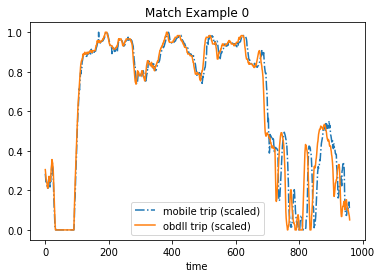

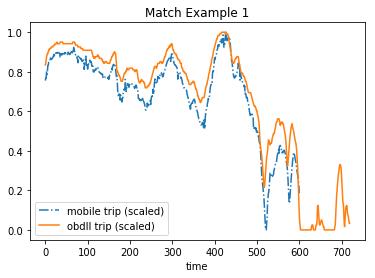

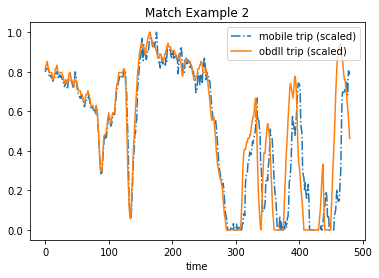

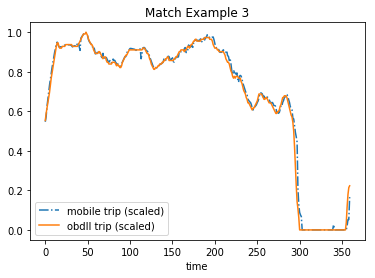

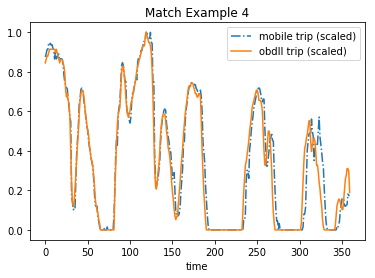

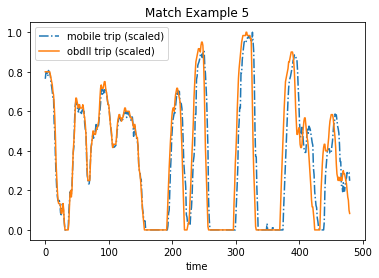

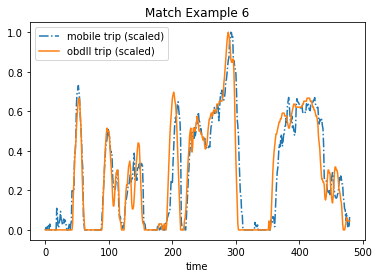

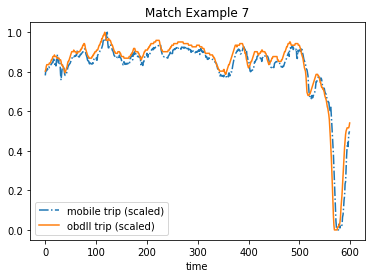

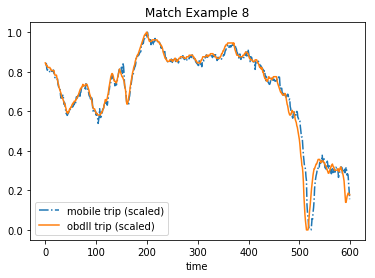

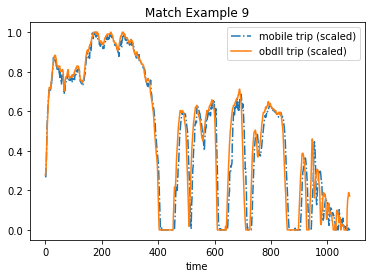

In [16]:
## matching example
for i,record in enumerate(match_record):
    x1, x2= plot(record)
    plt.plot(x1, '-.', label = 'mobile trip (scaled)')
    plt.plot(x2, '-', label = 'obdII trip (scaled)')
    plt.xlabel('time')
    plt.title('Match Example {0}'.format(i))
    plt.legend()
    plt.show()

## Future Improvement
Following items are for further enhance the performance upon the benchmark run

### Improve Benchmark Performance
* With the help of multi-processing, the performance can be significantly enhanced. <br><br>

* Fine tune the hyper parameters used in the benchmark (such as match length threshold, split size etc.<br><br>

* Better ways of sample, for example, half size segment: instead of rolling on trip B which is computationally costy, segment trip B with half size segementation on size A to increase computation meanwhile gurantee matching trips overlap. 

### Methodology


* Typically, decomposition methods such as Welch power density decomposition, Fourier transform or Wavelet transform in general can create features that helps in identify signals(preliminary implementaion see main_runner.py).<br><br>
* Lag(n) diff of data (for this dataset lag(1) diff measures acceleration) illustrate stationary property that potentially a better candidate to model. 
